# Neural Network

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install matplotlib

In [1]:
import utils
from utils import TrainingPlot, TimeSummary, plot_training_summary
from NNKeras import NNKeras
from sklearn.model_selection import train_test_split
import inspect
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Step 1
### Data Preparation

#### Data Cleanup
-  Merge 64 size vectors by ignoring line breaks
-  Create subset of data by selecting non consecutive vectors

#### Cleaned data
L42023,0.04347826,0.04347826,0.,0.04347826,0.01086957,0.02173913,0.,0.02173913,0.,0.,0.,0.,0.,0.02173913,0.02173913,0.04347826,0.07608696,0.02173913,0.,0.0326087,0.01086957,0.,0.,0.0326087,0.,0.01086957,0.,0.0326087,0.,0.,0.,0.0326087,0.05434783,0.,0.01086957,0.02173913,0.04347826,0.,0.01086957,0.02173913,0.02173913,0.,0.,0.01086957,0.0326087,0.,0.04347826,0.0326087,0.01086957,0.01086957,0.,0.02173913,0.04347826,0.01086957,0.,0.01086957,0.,0.,0.,0.,0.04347826,0.02173913,0.,0.

## Network 1
### Create input dataset X and y where X has all vectors and y is one-hot vector

In [2]:
nn = NNKeras("/tf/dataset/dataset.csv")
X, y, unique_classes = nn.read_data()

In [3]:
print("Input Vector Shape")
print(X.shape)
print("Initialized Training Vector Shape")
print(y.shape)
print("Input Vector Head")
print(X[:3])
print("Training Vector Head")
print(y[:3])
print("Categories")
unique_classes

Input Vector Shape
(3131, 64)
Initialized Training Vector Shape
(3131, 31)
Input Vector Head
         1         2         3         4         5         6         7   \
0  0.045455  0.045455  0.000000  0.000000  0.045455  0.318182  0.000000   
1  0.080000  0.060000  0.000000  0.100000  0.000000  0.000000  0.020000   
2  0.010482  0.020964  0.002096  0.012579  0.004193  0.031447  0.006289   

         8    9         10  ...        55        56        57        58  \
0  0.000000  0.0  0.045455  ...  0.000000  0.000000  0.045455  0.000000   
1  0.000000  0.0  0.000000  ...  0.000000  0.020000  0.020000  0.040000   
2  0.006289  0.0  0.014675  ...  0.010482  0.006289  0.000000  0.010482   

        59        60        61        62        63        64  
0  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.00000  0.000000  0.020000  0.000000  0.000000  0.000000  
2  0.02935  0.008386  0.010482  0.020964  0.012579  0.054507  

[3 rows x 64 columns]
Training Vector Head
[[ True F

,0,indices
0,AE014075,1
1,AE006470,2
2,AE002161,3
3,AE000512,4
4,AE009442,5
5,AE002098,6
6,AE000666,7
7,BA000002,8
8,AL450380,9
9,AE000516,10


### Prepare Train and Test Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X_train[:3])
print(y_train[:3])

            1         2         3         4         5         6         7   \
2113  0.000000  0.013333  0.005333  0.000000  0.000000  0.026667  0.013333   
3029  0.075269  0.043011  0.043011  0.021505  0.000000  0.010753  0.000000   
2130  0.056338  0.004695  0.000000  0.046948  0.014085  0.000000  0.004695   

            8         9         10  ...        55        56        57     58  \
2113  0.000000  0.000000  0.008000  ...  0.018667  0.002667  0.002667  0.008   
3029  0.000000  0.021505  0.000000  ...  0.010753  0.000000  0.000000  0.000   
2130  0.023474  0.009390  0.004695  ...  0.004695  0.014085  0.000000  0.000   

            59       60        61        62        63        64  
2113  0.016000  0.00000  0.000000  0.029333  0.002667  0.000000  
3029  0.010753  0.00000  0.021505  0.010753  0.010753  0.010753  
2130  0.009390  0.00939  0.042254  0.004695  0.037559  0.028169  

[3 rows x 64 columns]
[[False False False False False False False False False False False False
  Fal

## Step 2
### Network 1
-  Create neural network with single hidden layer
-  Use **Accuracy** as metric of performance  


In [5]:
inspect.getsourcelines(nn.train)
inspect.getsourcelines(nn.base_model)

(['    def base_model(self, nodes, num_output=31, kernel_regularizer=None, layer_id=None):\n',
  '        model = Sequential()\n',
  '        for prev_node, node in zip(nodes[:-1], nodes[1:]):\n',
  '            layer_name = None\n',
  '            if layer_id is not None:\n',
  '                layer_name = "{}-in-{}-n-{}".format(layer_id, str(prev_node), str(prev_node))\n',
  "            model.add(Dense(node, activation='relu', kernel_regularizer=kernel_regularizer,\n",
  '                            input_dim=prev_node, name=layer_name))\n',
  "        model.add(Dense(num_output, activation='sigmoid', name='features'))\n",
  "        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n",
  '        return model\n'],
 38)

In [6]:
nn.train(X, y, False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
32/32 [==============================] - 0s 1ms/step
Test loss: 0.14263762533664703
Test accuracy: 0.9677419066429138


>  With just single layer we are getting accuracy of 97% Epoch=10

## Step 3
### Network 2
-  Use the same model as step 1 for neurons  = 5 to 32
-  Measure accuracy at each step to find optimal number of neurons

In [7]:
inspect.getsourcelines(nn.train_network_2)

(['    def train_network_2(self, X, y):\n',
  '        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)\n',
  '        for P in range(2, 12):\n',
  '            for num_layers in range(1, 2):\n',
  '                nodes = [64] + [int(P / 2)] * num_layers\n',
  '                print(nodes)\n',
  '                model = self.base_model(nodes)\n',
  '                summary = model.fit(X_train, y_train, epochs=10, verbose=0)\n',
  '                score = model.evaluate(X_test, y_test)\n',
  "                print('Test loss:', score[0])\n",
  "                print('Test accuracy:', score[1])\n"],
 112)

In [8]:
nn.train_network_2(X, y)

[64, 1]
157/157 [==============================] - 0s 444us/step
Test loss: 0.1588774408884109
Test accuracy: 0.9677418956331386
[64, 1]
157/157 [==============================] - 0s 780us/step
Test loss: 0.16036453472960527
Test accuracy: 0.9677418956331386
[64, 2]
157/157 [==============================] - 0s 663us/step
Test loss: 0.14418551259359735
Test accuracy: 0.9677418956331386
[64, 2]
157/157 [==============================] - 0s 822us/step
Test loss: 0.1449950758818608
Test accuracy: 0.9677418956331386
[64, 3]
157/157 [==============================] - 0s 1ms/step
Test loss: 0.14400415710962503
Test accuracy: 0.9677418956331386
[64, 3]
157/157 [==============================] - 0s 1ms/step
Test loss: 0.14309968870536538
Test accuracy: 0.9677418956331386
[64, 4]
157/157 [==============================] - 0s 1ms/step
Test loss: 0.14563718295780717
Test accuracy: 0.9677418956331386
[64, 4]
157/157 [==============================] - 0s 1ms/step
Test loss: 0.14383558416442507
Test

>  ### Accuraccy is already at 96% in step 1, so we add regularize function to decrease accuracy and determine optimal number of neurons as 6
>  ### P=6 

## Step 4
### Network 3
-  Find optimal number of hidden layers with number of neurons as P/2
-  Again, since the accuracy is very high, we will have to take regularizer function
-  P=6, Number of neurons = P/2

In [9]:
inspect.getsourcelines(nn.train_network_3)

(['    def train_network_3(self, X, y):\n',
  '        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)\n',
  '        P = 6\n',
  '        for num_layers in range(1, 10):\n',
  '            nodes = [64] + [int(P / 2)] * num_layers\n',
  '            model = self.base_model(nodes)\n',
  '            summary = model.fit(X_train, y_train, epochs=10, verbose=0)\n',
  '            score = model.evaluate(X_test, y_test)\n',
  "            print('Test loss:', score[0])\n",
  "            print('Test accuracy:', score[1])\n"],
 101)

In [10]:
nn.train_network_3(X, y)

157/157 [==============================] - 0s 2ms/step
Test loss: 0.14383499533127828
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Test loss: 0.14350914395159217
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Test loss: 0.3905958024559507
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Test loss: 0.14274623999550085
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 3ms/step
Test loss: 0.19446207032461835
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 3ms/step
Test loss: 0.14286264558886266
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 3ms/step
Test loss: 0.39059823599590615
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 4ms/step
Test loss: 0.39061075411025126
Test accuracy: 0.9677418956331386
157/157 [==============================] 

>  ### Because of high accuracy, we can select number of layers=6

## Step 5
### Network 4
-  Without any conditions, determine optimal architecture
-  We can run the training module with P=6 and Layers=6
-  Save model for validation

In [11]:
inspect.getsourcelines(nn.train_with_callback)

(['    def train_with_callback(self, X, y, model_file: str = None, generate_plots=True):\n',
  '        if model_file is None:\n',
  '            model_file = self._model\n',
  '        plot_losses = TrainingPlot()\n',
  '        time_summary = TimeSummary()\n',
  "        layer_names = ['features']\n",
  '        num_nodes = 6\n',
  '        for layer_id in range(6, 7):\n',
  '            nodes = [64, num_nodes]\n',
  '            for prev_node, node in zip(nodes[:-1], nodes[1:]):\n',
  '                layer_name = None\n',
  '                if layer_id is not None:\n',
  '                    layer_name = "{}-in-{}-n-{}".format(layer_id, str(prev_node), str(prev_node))\n',
  '                    layer_names.append(layer_name)\n',
  '\n',
  '        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=5)\n',
  "        with open(os.path.join(self._log_dir, 'metadata.tsv'), 'w') as f:\n",
  '            np.savetxt(f, y_test)\n',
  '        tensorboard

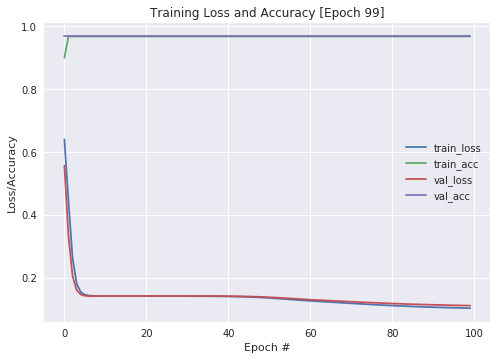

32/32 [==============================] - 0s 99us/step
Training time: 0:05:26.290941
Epoch time avg: 0:00:02.197360


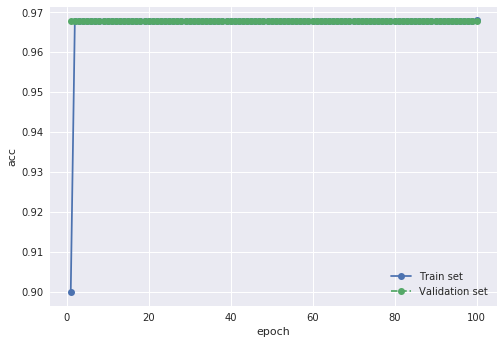

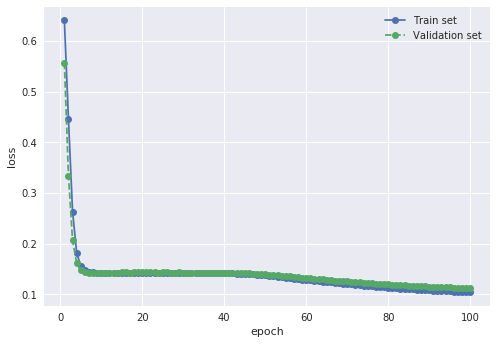

32/32 [==============================] - 0s 74us/step
Test loss: 0.11200548708438873
Test accuracy: 0.9677419066429138


In [12]:
nn.train_with_callback(X, y, '/tf/models/model.h5')

# Validation
### In this dataset, our neural network reaches accuracy of 96% with sample data and 98% with full dataset. Hence it is necessary to validate the accuracy of data with trained model.
### Keras allows callbacks for training visualization. Function below runs for 200 epochs with 32 neurons and saves the model

### Predict from souce data

In [13]:
inspect.getsourcelines(nn.predict)

(['    def predict(self, file_path: str, classes: [], num_lines: int = 30, model_file: str = None):\n',
  '        if model_file is None:\n',
  '            model_file = self._model\n',
  '        model = load_model(model_file)\n',
  '        with open(file_path, "r") as fp:\n',
  '            for i, line in enumerate(fp):\n',
  '                predict_vector = np.array(line.split(",")).astype(float).reshape(1, 64)\n',
  '                prediction = model.predict_classes(predict_vector)\n',
  '                print(classes[0].values[prediction])\n',
  '                if i > num_lines:\n',
  '                    break\n'],
 138)

In [14]:
nn.predict("/tf/dataset/ae002161.csv", unique_classes, 5, "/tf/models/model_full.h5")

['AE002161']
['AE002161']
['AE002161']
['AE002161']
['AE005672']
['AE002161']
['AE002161']


In [15]:
nn.predict("/tf/dataset/ae003852.csv", unique_classes, 5, "/tf/models/model_full.h5")

['BA000004']
['AE014075']
['AE003852']
['AE003852']
['AE003853']
['AE003852']
['AE014075']


>  ### As we can see that the accuracy is as expected for the first case but for second, it is less than expected.

## Step 6
### Network 5
-  We will use same training function with each column of y as 1D matrix
-  Take average of each inidividual prediction

In [16]:
inspect.getsourcelines(nn.single_output_score)

(['    def single_output_score(self, X, y):\n',
  '        total_score = 0\n',
  '        for y_i in range(self._num_classes - 1):\n',
  '            X_train, X_test, y_train, y_test = train_test_split(X, y[:, y_i], test_size=0.05, random_state=5)\n',
  '            num_nodes = 6\n',
  '            nodes = [64, num_nodes]\n',
  '            model = self.base_model(nodes, 1)\n',
  '            summary = model.fit(X_train, y_train, epochs=10, verbose=0)\n',
  '            score = model.evaluate(X_test, y_test)\n',
  "            print('Test loss:', score[0])\n",
  "            print('Test accuracy:', score[1])\n",
  '            total_score += score[1]\n',
  '        return total_score / self._num_classes\n'],
 124)

In [17]:
avg_score = nn.single_output_score(X, y)
avg_score

157/157 [==============================] - 1s 5ms/step
Test loss: 0.0777047333444
Test accuracy: 0.9872611430799885
157/157 [==============================] - 1s 5ms/step
Test loss: 0.39538617422626277
Test accuracy: 0.961783436073619
157/157 [==============================] - 1s 5ms/step
Test loss: 0.1386727728186899
Test accuracy: 0.9681528662420382
157/157 [==============================] - 1s 5ms/step
Test loss: 0.11822012503435657
Test accuracy: 0.9745222971697521
157/157 [==============================] - 1s 5ms/step
Test loss: 0.09647243949258404
Test accuracy: 0.9808917163283961
157/157 [==============================] - 1s 6ms/step
Test loss: 0.20027414514760303
Test accuracy: 0.9490445833297292
157/157 [==============================] - 1s 6ms/step
Test loss: 0.19537957686527518
Test accuracy: 0.9490445901633827
157/157 [==============================] - 1s 6ms/step
Test loss: 0.11481579246035048
Test accuracy: 0.9745222895768038
157/157 [==============================] - 1s 

0.9373330589998471

>  ### Average accuracy of individual prediction is less than overall prediction accuracy. Hence, we can conclude that it is better to create one network with N output neurons than N networks each with one output neuron.

## Next Steps
-  ### Generic module for generating optimized network
-  ### Visualize t-SNE for hidden layers

---

## Validation with linear classification methods

In [18]:
##############  Validation with linear classification methods

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X.shape)
print(y.shape)

tmp = DecisionTreeClassifier(min_samples_leaf=10)
tmp.fit(X_train, y_train)
y_pred = tmp.predict(X_test)
print('test', accuracy_score(y_pred, y_test))
y_pred_train = tmp.predict(X_train)
print('train', accuracy_score(y_pred_train, y_train))

(3131, 64)
(3131, 31)
test 0.26953748006379585
train 0.46246006389776356


In [ ]:
##############  Validation with linear classification methods

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
# print(pca.components_)
X_proj = pca.transform(X_test)

f, ax = plt.subplots(2, sharex=True)
f.set_figheight(10)
ax[0].scatter(X_proj[:, 0], X_proj[:, 1], c=np.argmax(y_test, axis=1), alpha=0.9)
ax[1].scatter(X_proj[:, 0], X_proj[:, 1], c=np.argmax(y_pred, axis=1), alpha=0.9)